<a href="https://colab.research.google.com/github/takuma-uchida/google_colab_uchida/blob/main/%E3%80%90HRT%E3%80%91%E9%81%A9%E6%80%A7%E3%83%9E%E3%83%83%E3%83%81%E3%83%B3%E3%82%B0_%E5%80%8B%E4%BA%BA%E5%AF%BE%E5%80%8B%E4%BA%BA_HRT%E3%83%A1%E3%83%B3%E3%83%90%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 初期設定

## ドライブ認証等

In [1]:
#ドライブのマウント
from google.colab import drive
drive.mount('/content/drive')

#認証
from google.colab import auth
auth.authenticate_user()

Mounted at /content/drive


## ライブラリー読込

In [2]:
# matplotlibの日本語化に使用
!pip install japanize_matplotlib

#基本ライブラリー
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import japanize_matplotlib
import plotly.express as px
import time

#正規化
from sklearn.preprocessing import MinMaxScaler

#クラスター分析
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# マハラノビス距離
from scipy.spatial.distance import mahalanobis

# 多次元尺度構成法(MDS)
from sklearn.manifold import MDS

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 53.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=22d993afaf68992bf406f76b2f58727053bedde010ce0507512a0521b0a75649
  Stored in directory: /root/.cache/pip/wheels/da/a1/71/b8faeb93276fed10edffcca20746f1ef6f8d9e071eee8425fc
Successfully built japanize_matplotlib


## このコラボがいるファイルパスまで移動
  - ご自身のパス状況に合わせて編集してください。

In [3]:
#特定のディレクトリに移動
%cd /content/drive/My Drive/mar-データ戦略/事業施策/HRTech/[HRT]適性マッチのマッチングロジック

/content/drive/.shortcut-targets-by-id/1RLRkq0c3TMfT_n4FaUruqWK2YQsqpq_s/mar-データ戦略/事業施策/HRTech/[HRT]適性マッチのマッチングロジック


## BQからデータ読込

In [4]:
%%bigquery input_rawdata --project hrtech-datainfra-prod
/*
HRT_Nalysys
*/
select
  es.employee_id --pionaly回答者ID
  ,e.corporation_id --pionaly回答者の所属会社ID
  ,esf.factor_type_id --pionalyの各因子の名称
  ,esf.value --pionalyの各因子の因子スコア
  ,es.scoring_date --pionaly回答者の回答日
from
  `hrtech-datainfra-prod.view_worx_personal.employee_score_factors` as esf
left join
  `hrtech-datainfra-prod.view_worx_personal.employee_scores` as es
  on esf.score_id = es.id
left join
  `hrtech-datainfra-prod.view_worx_personal.employee_personals` as ep
  on es.employee_id = ep.id
left join
  `hrtech-datainfra-prod.view_worx_employee.employee` as e
  on ep.id = e.id
where
  es.is_answered = true --未回答者を除く（回答者に絞る）
  and es.type_id = 'pionaly' --pionaly回答者に絞る
order by
  employee_id

Query is running:   0%|          |

Downloading:   0%|          |

In [5]:
input_rawdata.head(5)

,employee_id,corporation_id,factor_type_id,value,scoring_date
0,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,optimism,5.739986406505343,2024-10-17 02:15:08
1,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,purposeful,3.4106594135368518,2024-10-17 02:15:08
2,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,supervision,6.430832085940616,2024-10-17 02:15:08
3,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,risk,2.6265415499900002,2024-10-17 02:15:08
4,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,openness,7.240682782310305,2024-10-17 02:15:08


## 「input_rawdata」を距離測定に使う因子のみのデータに絞る

In [6]:
# 「factor_type」の名称を追加
file_path = "factorTypeIdと因子名.csv"
factor_type_id_conversion = pd.read_csv(file_path, encoding='utf-8')  # エンコーディングを指定

input_rawdata = pd.merge(input_rawdata, factor_type_id_conversion, how ='left', on="factor_type_id")

factor_type_filtering = ["達成欲","活動性","競争心","慎重性","目的的"]
input_rawdata = input_rawdata[input_rawdata['factor_type_name'].isin(factor_type_filtering)]
input_data = input_rawdata.drop('factor_type_name', axis=1)
input_data

,employee_id,corporation_id,factor_type_id,value,scoring_date
1,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,purposeful,3.4106594135368518,2024-10-17 02:15:08
31,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,activity,3.612698031993185,2024-10-17 02:15:08
38,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,prudence,7.840908918682354,2024-10-17 02:15:08
54,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,competitiveness,5.4115411628121715,2024-10-17 02:15:08
58,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,achievement,3.9569429750859006,2024-10-17 02:15:08
...,...,...,...,...,...
390845,ffff3122-60fd-4795-9f85-0b20d0640222,76230de6-c0ec-42a6-a6c9-9c855f49419f,prudence,4.697138955939703,2024-11-09 21:10:04
390861,ffff3122-60fd-4795-9f85-0b20d0640222,76230de6-c0ec-42a6-a6c9-9c855f49419f,activity,5.730541769436478,2024-11-09 21:10:04
390868,ffff3122-60fd-4795-9f85-0b20d0640222,76230de6-c0ec-42a6-a6c9-9c855f49419f,achievement,5.408053816990008,2024-11-09 21:10:04
390873,ffff3122-60fd-4795-9f85-0b20d0640222,76230de6-c0ec-42a6-a6c9-9c855f49419f,competitiveness,5.480571715371566,2024-11-09 21:10:04


## 回答者idと企業idのファイル読込

In [7]:
# 回答者idと企業IDのデータ
employee_company_data = input_data[["employee_id", "corporation_id"]]
employee_company_data = employee_company_data.drop_duplicates(subset=["employee_id", "corporation_id"])
employee_company_data

,employee_id,corporation_id
1,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac
130,00188f3c-ea40-4312-8273-1d970e08c102,d299aad2-ecf8-4c79-b654-5a8fe3947c8f
161,0033e100-e265-45cb-8c98-2f20d4d54184,56f195ed-73e8-4efe-bdd5-4b26072e6080
245,004d1690-175d-484f-b35a-46326d8c2bcc,56f195ed-73e8-4efe-bdd5-4b26072e6080
309,00668205-2e2e-43e0-b375-5d04cff8f83a,None
...,...,...
390534,ffd67bfb-0309-4f64-89a5-38ae6930fb59,56f195ed-73e8-4efe-bdd5-4b26072e6080
390598,fff0847a-2668-4fa9-9980-bd7172c1a7e1,56f195ed-73e8-4efe-bdd5-4b26072e6080
390695,fff22958-1634-4517-b656-40b8095bc8bd,56f195ed-73e8-4efe-bdd5-4b26072e6080
390772,fff7ab5e-fe53-4704-9b9a-34b3e371ad47,56f195ed-73e8-4efe-bdd5-4b26072e6080


## 「input_data」をデータ成形

In [8]:
# 「value」をフロート値に変換
input_data["value"] = input_data["value"].astype(float)

# scoring_date列から「○○○○-○○-○○」を抽出
input_data['scoring_date'] = input_data['scoring_date'].astype(str).str[:10]

# scoring_dateをデータ型に変換
input_data["scoring_date"] = pd.to_datetime(input_data["scoring_date"])

# 各employee_idの最新のscoring_dateを取得
latest_scoring_dates = input_data.groupby('employee_id')['scoring_date'].max()

# 新しいカラム「is_latest」を追加し、初期値を0に設定
input_data['is_latest'] = 0

# 最新のscoring_dateを持つ行に1を設定
for employee_id, latest_date in latest_scoring_dates.items():
    input_data.loc[(input_data['employee_id'] == employee_id) & (input_data['scoring_date'] == latest_date), 'is_latest'] = 1

# is_latestが0のレコードを削除
input_data = input_data[input_data['is_latest'] == 1]

# 列を削除
input_data = input_data.drop(['is_latest', 'scoring_date'], axis=1)

#ダミー変数化
dummy_df = pd.get_dummies(input_data, columns=['factor_type_id'], prefix='', prefix_sep='', dtype=int)
for col in dummy_df.columns[2:]:
    dummy_df[col] = dummy_df[col] * dummy_df["value"]
dummy_df = dummy_df.drop("value", axis=1)
input_data = dummy_df.groupby("employee_id").sum().reset_index()

# 「employee_id」のHRテック従業員の名称を追加
file_path = "HRテック従業員_レバ全社員.csv"
employee_name = pd.read_csv(file_path, encoding='utf-8')
# Name1のフルネームを追加
input_data = pd.merge(input_data, employee_name, left_on='employee_id', right_on='employee_id', how='left')

input_data

,employee_id,corporation_id,achievement,activity,competitiveness,prudence,purposeful,fullname
0,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac89eac118-a...,15.657398,13.051587,29.284778,61.479853,11.632598,NaN
1,00188f3c-ea40-4312-8273-1d970e08c102,d299aad2-ecf8-4c79-b654-5a8fe3947c8fd299aad2-e...,27.002610,31.154509,30.853174,10.836194,9.985104,NaN
2,0033e100-e265-45cb-8c98-2f20d4d54184,56f195ed-73e8-4efe-bdd5-4b26072e608056f195ed-7...,12.095638,14.249119,12.148668,9.741497,30.835744,中野上 龍太郎
3,004d1690-175d-484f-b35a-46326d8c2bcc,56f195ed-73e8-4efe-bdd5-4b26072e608056f195ed-7...,69.267517,81.902503,61.963087,62.813212,28.297872,相月 俊紀
4,00668205-2e2e-43e0-b375-5d04cff8f83a,0,43.217670,47.606499,26.247285,20.289380,28.416568,佐藤 暖流
...,...,...,...,...,...,...,...,...
4797,ffd67bfb-0309-4f64-89a5-38ae6930fb59,56f195ed-73e8-4efe-bdd5-4b26072e608056f195ed-7...,21.492970,19.412114,9.959097,22.070865,23.984611,NaN
4798,fff0847a-2668-4fa9-9980-bd7172c1a7e1,56f195ed-73e8-4efe-bdd5-4b26072e608056f195ed-7...,9.246104,47.406644,40.304878,6.711362,42.254700,弘津 未彩
4799,fff22958-1634-4517-b656-40b8095bc8bd,56f195ed-73e8-4efe-bdd5-4b26072e608056f195ed-7...,22.150768,26.340899,21.993319,12.581268,52.906649,椛沢 はるな
4800,fff7ab5e-fe53-4704-9b9a-34b3e371ad47,56f195ed-73e8-4efe-bdd5-4b26072e608056f195ed-7...,46.153125,21.204100,46.679023,50.191048,33.069067,小泉 拓巳


## 回答者idと企業idのデータフレームを作成

In [9]:
# 回答者idと企業IDのデータ
employee_company_data = input_data[["employee_id", "corporation_id"]]
employee_company_data = employee_company_data.drop_duplicates(subset=["employee_id", "corporation_id"])
employee_company_data

,employee_id,corporation_id
0,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac89eac118-a...
1,00188f3c-ea40-4312-8273-1d970e08c102,d299aad2-ecf8-4c79-b654-5a8fe3947c8fd299aad2-e...
2,0033e100-e265-45cb-8c98-2f20d4d54184,56f195ed-73e8-4efe-bdd5-4b26072e608056f195ed-7...
3,004d1690-175d-484f-b35a-46326d8c2bcc,56f195ed-73e8-4efe-bdd5-4b26072e608056f195ed-7...
4,00668205-2e2e-43e0-b375-5d04cff8f83a,0
...,...,...
4797,ffd67bfb-0309-4f64-89a5-38ae6930fb59,56f195ed-73e8-4efe-bdd5-4b26072e608056f195ed-7...
4798,fff0847a-2668-4fa9-9980-bd7172c1a7e1,56f195ed-73e8-4efe-bdd5-4b26072e608056f195ed-7...
4799,fff22958-1634-4517-b656-40b8095bc8bd,56f195ed-73e8-4efe-bdd5-4b26072e608056f195ed-7...
4800,fff7ab5e-fe53-4704-9b9a-34b3e371ad47,56f195ed-73e8-4efe-bdd5-4b26072e608056f195ed-7...


## 回答者idと正規化した因子スコアのデータフレームを作成

In [10]:
# 因子スコアを正規化
scaler = MinMaxScaler()
factor_score = input_data.columns.difference(['employee_id', 'fullname', 'corporation_id'])
factor_score_scaling = input_data.copy()
factor_score_scaling[factor_score] = scaler.fit_transform(factor_score_scaling[factor_score])*100
factor_score_scaling = factor_score_scaling.drop('corporation_id', axis=1)
factor_score_scaling.head(5)

,employee_id,achievement,activity,competitiveness,prudence,purposeful,fullname
0,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,15.657398,13.051587,36.520728,72.275863,12.109164,NaN
1,00188f3c-ea40-4312-8273-1d970e08c102,27.002610,31.154509,38.476657,12.739056,10.368062,NaN
2,0033e100-e265-45cb-8c98-2f20d4d54184,12.095638,14.249119,15.150472,11.452127,32.403411,中野上 龍太郎
3,004d1690-175d-484f-b35a-46326d8c2bcc,69.267517,81.902503,77.273492,73.843363,29.721340,相月 俊紀
4,00668205-2e2e-43e0-b375-5d04cff8f83a,43.217670,47.606499,32.732703,23.852244,29.846780,佐藤 暖流


# ユークリッド距離

## ユークリッド距離_実装
  - データ量が多いため、処理速度が速いmumpy配列に変換し、「input_data」を分割してユークリッド距離を算出

### 分割した「input_data」をnumpy配列に変換

In [ ]:
# 必要なカラムのみ抽出
columns_to_extract = ['achievement', 'activity', 'competitiveness', 'prudence', 'purposeful']
filtered_data = input_data[columns_to_extract]

# データ型をfloatに明示的に変換（エラーの場合はNaNに置き換え）
filtered_data = filtered_data.apply(pd.to_numeric, errors='coerce')

# NaNを含む行を削除
filtered_data = filtered_data.dropna()

# 明示的にfloat型のnumpy配列に変換
data_array = filtered_data.to_numpy(dtype=float)

# 対応するemployee_idを取得
ids_array = input_data.loc[filtered_data.index, "employee_id"].to_numpy()

# ユニークなemployee_idを取得
names = np.unique(ids_array)

### ユークリッド距離を測定

In [ ]:
# ユークリッド距離を計算
# 全データ(4738行)で実行時間は13分ほど、レコード数は2629368
euclid_distance_1 = []
for i in range(len(names) // 8):
    for j in range(i + 1, len(names)):
        index1 = np.where(ids_array == names[i])[0][0]
        index2 = np.where(ids_array == names[j])[0][0]
        distance = np.linalg.norm(data_array[index1] - data_array[index2])  # ユークリッド距離
        euclid_distance_1.append([names[i], names[j], distance])

In [ ]:
len(euclid_distance_1)

2673963

In [ ]:
# ユークリッド距離を計算
# 全データ(4738行)で実行時間は15分ほど、レコード数は2278904
euclid_distance_2 = []
for i in range(len(names) // 8, len(names) // 4):
    for j in range(i + 1, len(names)):
        index1 = np.where(ids_array == names[i])[0][0]
        index2 = np.where(ids_array == names[j])[0][0]
        distance = np.linalg.norm(data_array[index1] - data_array[index2])  # ユークリッド距離
        euclid_distance_2.append([names[i], names[j], distance])

In [ ]:
len(euclid_distance_2)

2317554

In [ ]:
# ユークリッド距離を計算
# 全データ(4738行)で実行時間は14分ほど、レコード数は2273778
euclid_distance_3 = []
for i in range(len(names) // 4, int(len(names) // 2.5)):
    for j in range(i + 1, len(names)):
        index1 = np.where(ids_array == names[i])[0][0]
        index2 = np.where(ids_array == names[j])[0][0]
        distance = np.linalg.norm(data_array[index1] - data_array[index2])  # ユークリッド距離
        euclid_distance_3.append([names[i], names[j], distance])

In [ ]:
len(euclid_distance_3)

2312325

In [ ]:
# ユークリッド距離を計算
# 全データ(4738行)で実行時間は10分ほど、レコード数は1978438
euclid_distance_4 = []
for i in range(int(len(names) // 2.5), int(len(names) // 1.75)):
    for j in range(i + 1, len(names)):
        index1 = np.where(ids_array == names[i])[0][0]
        index2 = np.where(ids_array == names[j])[0][0]
        distance = np.linalg.norm(data_array[index1] - data_array[index2])  # ユークリッド距離
        euclid_distance_4.append([names[i], names[j], distance])

In [ ]:
len(euclid_distance_4)

2012283

In [ ]:
# ユークリッド距離を計算
# 全データ(4738行)で実行時間は15分ほど、レコード数は1524299
euclid_distance_5 = []
for i in range(int(len(names) // 1.75), int(len(names) // 1.28)):
    for j in range(i + 1, len(names)):
        index1 = np.where(ids_array == names[i])[0][0]
        index2 = np.where(ids_array == names[j])[0][0]
        distance = np.linalg.norm(data_array[index1] - data_array[index2])  # ユークリッド距離
        euclid_distance_5.append([names[i], names[j], distance])

In [ ]:
len(euclid_distance_5)

1549593

In [ ]:
# ユークリッド距離を計算
# 全データ(4738行)で実行時間は3分ほど、レコード数は537166
euclid_distance_6 = []
for i in range(int(len(names) // 1.28), len(names)):
    for j in range(i + 1, len(names)):
        index1 = np.where(ids_array == names[i])[0][0]
        index2 = np.where(ids_array == names[j])[0][0]
        distance = np.linalg.norm(data_array[index1] - data_array[index2])  # ユークリッド距離
        euclid_distance_6.append([names[i], names[j], distance])

In [ ]:
len(euclid_distance_6)

546535

### 分割したユークリッド距離を結合し、データ成形

In [ ]:
# 「euclid_distance_1」～「euclid_distance_6」の結合
euclid_distance = euclid_distance_1 + euclid_distance_2 + euclid_distance_3 + euclid_distance_4 + euclid_distance_5 + euclid_distance_6

# データフレーム化
euclid_distance_df = pd.DataFrame(euclid_distance, columns=['Name1', 'Name2', 'Distance'])

# ユークリッド距離を正規化
scaler = MinMaxScaler()
euclid_distance_df['Distance'] = scaler.fit_transform(euclid_distance_df[['Distance']])*100

# 距離の値を小数点第2位で四捨五入
euclid_distance_df["Distance"] = round(euclid_distance_df["Distance"],2)
euclid_distance_df.head(3)

,Name1,Name2,Distance
0,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,00188f3c-ea40-4312-8273-1d970e08c102,20.69
1,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,0033e100-e265-45cb-8c98-2f20d4d54184,22.45
2,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,004d1690-175d-484f-b35a-46326d8c2bcc,30.88


### 「euclid_distance_df」に企業idを追加

In [ ]:
# Name1のcorporation_idを追加
euclid_distance_df = pd.merge(euclid_distance_df, employee_company_data, left_on='Name1', right_on='employee_id', how='left')
euclid_distance_df = euclid_distance_df.rename(columns={'corporation_id': 'Name1_corporation_id'})
euclid_distance_df = euclid_distance_df.drop('employee_id', axis=1)

# Name2のcorporation_idを追加
euclid_distance_df = pd.merge(euclid_distance_df, employee_company_data, left_on='Name2', right_on='employee_id', how='left')
euclid_distance_df = euclid_distance_df.rename(columns={'corporation_id': 'Name2_corporation_id'})
euclid_distance_df = euclid_distance_df.drop('employee_id', axis=1)

# # カラムの順序変更
new_column_order = ['Name1', 'Name1_corporation_id','Name2', 'Name2_corporation_id', 'Distance']
euclid_distance_df = euclid_distance_df[new_column_order]
euclid_distance_df.head(5)

,Name1,Name1_corporation_id,Name2,Name2_corporation_id,Distance
0,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,00188f3c-ea40-4312-8273-1d970e08c102,d299aad2-ecf8-4c79-b654-5a8fe3947c8f,20.69
1,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,0033e100-e265-45cb-8c98-2f20d4d54184,56f195ed-73e8-4efe-bdd5-4b26072e6080,22.45
2,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,004d1690-175d-484f-b35a-46326d8c2bcc,56f195ed-73e8-4efe-bdd5-4b26072e6080,30.88
3,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,00668205-2e2e-43e0-b375-5d04cff8f83a,None,23.07
4,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,00857a9d-9622-4c65-983e-ae062d6e2b19,56f195ed-73e8-4efe-bdd5-4b26072e6080,21.94


### 「euclid_distance_df」に因子スコア（正規化済み）を追加
  - ユークリッド距離算出によるローデータが「euclid_distance_df」

In [ ]:
# Name1の因子データを追加
cluster_df = pd.merge(euclid_distance_df, factor_score_scaling, left_on='Name1', right_on='employee_id', how='left')
cluster_df = cluster_df.rename(columns={'achievement': 'Name1_achievement', 'activity': 'Name1_activity','competitiveness':'Name1_competitiveness'
                                          , 'prudence':'Name1_prudence','purposeful':'Name1_purposeful', 'fullname':'Name1_fullname'})

# Name2の因子データを追加
cluster_df = pd.merge(cluster_df, factor_score_scaling, left_on='Name2', right_on='employee_id', how='left')
cluster_df = cluster_df.drop(['employee_id_x','employee_id_y'], axis=1)
euclid_distance_df = cluster_df.rename(columns={'achievement': 'Name2_achievement', 'activity': 'Name2_activity',
                                          'competitiveness':'Name2_competitiveness', 'prudence':'Name2_prudence','purposeful':'Name2_purposeful', 'fullname':'Name2_fullname'})

# カラムの順序変更
new_column_order = ['Name1', 'Name1_fullname', 'Name1_corporation_id','Name1_achievement','Name1_activity','Name1_competitiveness','Name1_prudence','Name1_purposeful',
                    'Name2', 'Name2_fullname', 'Name2_corporation_id','Name2_achievement','Name2_activity','Name2_competitiveness','Name2_prudence','Name2_purposeful', 'Distance']
euclid_distance_df = euclid_distance_df[new_column_order]
euclid_distance_df.head(5)

,Name1,Name1_fullname,Name1_corporation_id,Name1_achievement,Name1_activity,Name1_competitiveness,Name1_prudence,Name1_purposeful,Name2,Name2_fullname,Name2_corporation_id,Name2_achievement,Name2_activity,Name2_competitiveness,Name2_prudence,Name2_purposeful,Distance
0,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,NaN,89eac118-a1ce-45a2-847c-c78c435193ac,39.56943,27.359309,43.171676,67.420275,22.416351,00188f3c-ea40-4312-8273-1d970e08c102,NaN,d299aad2-ecf8-4c79-b654-5a8fe3947c8f,51.964035,42.270162,44.312664,28.304957,20.538403,20.69
1,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,NaN,89eac118-a1ce-45a2-847c-c78c435193ac,39.56943,27.359309,43.171676,67.420275,22.416351,0033e100-e265-45cb-8c98-2f20d4d54184,中野上 龍太郎,56f195ed-73e8-4efe-bdd5-4b26072e6080,34.778784,28.586927,27.806241,26.837185,38.461765,22.45
2,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,NaN,89eac118-a1ce-45a2-847c-c78c435193ac,39.56943,27.359309,43.171676,67.420275,22.416351,004d1690-175d-484f-b35a-46326d8c2bcc,相月 俊紀,56f195ed-73e8-4efe-bdd5-4b26072e6080,83.227109,68.536519,62.797805,68.147450,36.713525,30.88
3,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,NaN,89eac118-a1ce-45a2-847c-c78c435193ac,39.56943,27.359309,43.171676,67.420275,22.416351,00668205-2e2e-43e0-b375-5d04cff8f83a,佐藤 暖流,None,65.740148,52.252440,40.871458,38.730981,36.796996,23.07
4,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,NaN,89eac118-a1ce-45a2-847c-c78c435193ac,39.56943,27.359309,43.171676,67.420275,22.416351,00857a9d-9622-4c65-983e-ae062d6e2b19,ルパワッタゲ アナン,56f195ed-73e8-4efe-bdd5-4b26072e6080,38.825621,41.243004,51.677788,26.170210,32.813109,21.94


## HRTメンバに絞る

In [ ]:
hrt_member = [
"河村 彰哉",
"杼木 悠人",
"小奈 百花",
"森脇 斗也",
"白井 陽平",
"福井 凪桜",
"佐藤 暖流",
"大滝 圭修",
"齋藤 匠",
"石田 貴義",
"德永 眞哉",
"塚本 貴之",
"川口 耀平",
"関口 一騎",
"下畑剣 一郎",
"稲村 麟",
"香川 淳",
"三口 廉",
"松本 悠太郎",
"岡本 侑樹",
"縄巻 一鴻",
"桐生 直輝",
"山下 翔",
"佐々木 美奈",
"三浦 一希",
"山本 寛太",
"岡島 喜希",
"牧野 航大",
"岩本 健太郎",
"𠮷田 球花",
"矢野 貴大",
"瀬上 真宏"
]

In [ ]:
# Name1がHRTメンバーに絞る
euclid_distance_hrt = euclid_distance_df[euclid_distance_df['Name1_fullname'].isin(hrt_member)].reset_index(drop=True)

# Name2がHRTメンバーに絞る
euclid_distance_hrt = euclid_distance_hrt[euclid_distance_hrt['Name2_fullname'].isin(hrt_member)].reset_index(drop=True)
euclid_distance_hrt.head(3)

,Name1,Name1_fullname,Name1_corporation_id,Name1_achievement,Name1_activity,Name1_competitiveness,Name1_prudence,Name1_purposeful,Name2,Name2_fullname,Name2_corporation_id,Name2_achievement,Name2_activity,Name2_competitiveness,Name2_prudence,Name2_purposeful,Distance
0,00668205-2e2e-43e0-b375-5d04cff8f83a,佐藤 暖流,None,65.740148,52.25244,40.871458,38.730981,36.796996,02e7a636-5d12-47d8-8a06-398ca38f9f8a,大滝 圭修,56f195ed-73e8-4efe-bdd5-4b26072e6080,85.518198,63.298709,61.066974,22.145851,43.806401,16.69
1,00668205-2e2e-43e0-b375-5d04cff8f83a,佐藤 暖流,None,65.740148,52.25244,40.871458,38.730981,36.796996,036f4d62-1e0d-40cd-a84d-b8e0dbe05b08,森脇 斗也,56f195ed-73e8-4efe-bdd5-4b26072e6080,52.608814,46.009256,46.372544,38.725768,37.794618,6.88
2,00668205-2e2e-43e0-b375-5d04cff8f83a,佐藤 暖流,None,65.740148,52.25244,40.871458,38.730981,36.796996,0c88429e-68b4-4b3f-88ff-8763b06eb3c4,三口 廉,56f195ed-73e8-4efe-bdd5-4b26072e6080,42.062806,40.052106,19.839082,58.627162,32.474569,18.46


In [ ]:
# fullnameがHRTメンバーに絞る
input_data_hrt = input_data[input_data['fullname'].isin(hrt_member)].reset_index(drop=True)
input_data_hrt.head(3)

,employee_id,achievement,activity,competitiveness,prudence,purposeful,fullname
0,00668205-2e2e-43e0-b375-5d04cff8f83a,6.574015,6.899746,5.123210,4.504373,5.330719,佐藤 暖流
1,02e7a636-5d12-47d8-8a06-398ca38f9f8a,8.551820,8.358366,7.654705,2.575540,6.266594,大滝 圭修
2,036f4d62-1e0d-40cd-a84d-b8e0dbe05b08,5.260881,6.075356,5.812768,4.503767,5.463919,森脇 斗也


## ユークリッド距離_クラスター分析

### エルボー法

In [ ]:
#エルボー法
def elbow_method(max_cluster_num, input_data):
  input_data_values = input_data.drop(['employee_id', 'fullname'], axis=1).values

  sse = []
  for i in range(1, max_cluster_num+1):
      kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
      kmeans.fit(input_data_values)
      sse.append(kmeans.inertia_) #SSEを取得

  # plt.figure(figsize=(10,5))
  plt.plot(range(1, max_cluster_num+1), sse, marker='o', linestyle='--')
  plt.xticks(range(1, max_cluster_num+1))

  plt.title('Elbow Method')
  plt.xlabel('Number of clusters')
  plt.ylabel('SSE')
  plt.show()

  return plt.show()

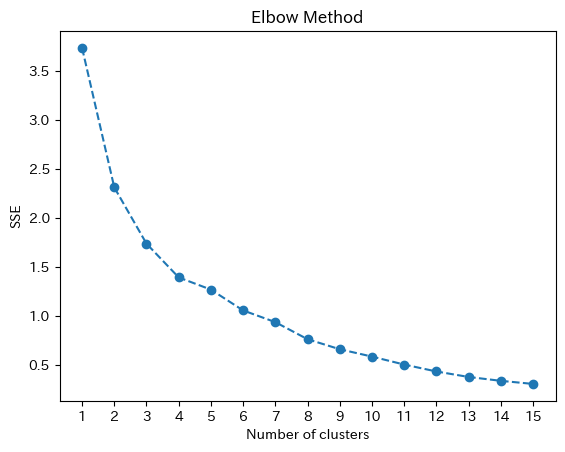

In [ ]:
#【def】エルボー法を実行
elbow_method(max_cluster_num= 15, input_data = input_data_hrt)

### 非階層型クラスター分析

In [ ]:
#ユークリッド距離_クラスター分析
def kmeans_euclid(n_clusters, input_data, random_state):
  X = input_data.drop(['employee_id', 'fullname'], axis=1)

  # KMeans法を実施し、クラスターを構築
  clf = KMeans(n_clusters=n_clusters, n_init=20, random_state=random_state)
  clf.fit(X)
  clusters = clf.labels_

  # クラスター番号を付与
  input_data["cluster"] = clusters

  return input_data

In [ ]:
# 【def】ユークリッド距離_クラスター分析を実行
input_data_hrt = kmeans_euclid(n_clusters=3,input_data=input_data_hrt, random_state=42)

In [ ]:
# クラスタリングを追加
euclid_distance_hrt = pd.merge(euclid_distance_hrt, input_data_hrt[["employee_id", "cluster"]], left_on='Name1', right_on='employee_id', how='left')
euclid_distance_hrt = euclid_distance_hrt.rename(columns={'cluster': 'Name1_cluster'})
euclid_distance_hrt.head(3)

,Name1,Name1_fullname,Name1_corporation_id,Name1_achievement,Name1_activity,Name1_competitiveness,Name1_prudence,Name1_purposeful,Name2,Name2_fullname,Name2_corporation_id,Name2_achievement,Name2_activity,Name2_competitiveness,Name2_prudence,Name2_purposeful,Distance,employee_id,Name1_cluster
0,00668205-2e2e-43e0-b375-5d04cff8f83a,佐藤 暖流,None,65.740148,52.25244,40.871458,38.730981,36.796996,02e7a636-5d12-47d8-8a06-398ca38f9f8a,大滝 圭修,56f195ed-73e8-4efe-bdd5-4b26072e6080,85.518198,63.298709,61.066974,22.145851,43.806401,16.69,00668205-2e2e-43e0-b375-5d04cff8f83a,0
1,00668205-2e2e-43e0-b375-5d04cff8f83a,佐藤 暖流,None,65.740148,52.25244,40.871458,38.730981,36.796996,036f4d62-1e0d-40cd-a84d-b8e0dbe05b08,森脇 斗也,56f195ed-73e8-4efe-bdd5-4b26072e6080,52.608814,46.009256,46.372544,38.725768,37.794618,6.88,00668205-2e2e-43e0-b375-5d04cff8f83a,0
2,00668205-2e2e-43e0-b375-5d04cff8f83a,佐藤 暖流,None,65.740148,52.25244,40.871458,38.730981,36.796996,0c88429e-68b4-4b3f-88ff-8763b06eb3c4,三口 廉,56f195ed-73e8-4efe-bdd5-4b26072e6080,42.062806,40.052106,19.839082,58.627162,32.474569,18.46,00668205-2e2e-43e0-b375-5d04cff8f83a,0


### 各回答者のユークリッド距離を可視化

In [ ]:
def mds(distance_df):
  # 距離行列の作成
  names = list(set(distance_df["Name1_fullname"]).union(set(distance_df["Name2_fullname"])))
  distance_matrix = pd.DataFrame(index=names, columns=names, data=np.nan)

  # データを距離行列に埋める
  distance_df_1 = distance_df[["Name1_fullname","Name2_fullname","Distance"]]
  for _, row in distance_df_1.iterrows():
      distance_matrix.loc[row["Name1_fullname"], row["Name2_fullname"]] = row["Distance"]
      distance_matrix.loc[row["Name2_fullname"], row["Name1_fullname"]] = row["Distance"]

  # NaN を埋める (未定義の距離をゼロに置換)
  distance_matrix = distance_matrix.fillna(0)

  # 多次元尺度構成法 (MDS)
  mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
  embedding = mds.fit_transform(distance_matrix)

  # データフレーム化
  mds_df = pd.DataFrame(embedding, columns=["Dim1", "Dim2"], index=names).reset_index()
  mds_df.rename(columns={"index": "Name"}, inplace=True)

  # 可視化 (Plotly)
  fig = px.scatter(
      mds_df,
      x="Dim1",
      y="Dim2",
      # color="Name1_cluster",
      text="Name",
      title="多次元尺度構成法 (MDS) による可視化",
      labels={"Dim1": "次元 1", "Dim2": "次元 2"},
      # width=figsize[0] * 100,
      # height=figsize[1] * 100,
  )
  fig.update_traces(textposition='top center')
  fig.show()

  return mds_df

In [ ]:
# ユークリッド距離：euclid_distance_df
euclid_mds_df = mds(euclid_distance_hrt)

### ユークリッド距離のヒストグラム

<Axes: >

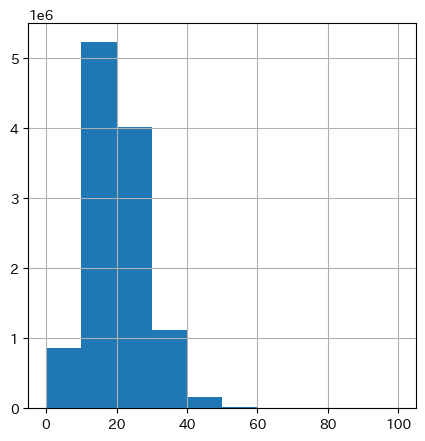

In [ ]:
euclid_distance_df["Distance"].hist(figsize=(5,5))

### 各因子のヒストグラム

array([[<Axes: title={'center': 'achievement'}>,
        <Axes: title={'center': 'activity'}>],
       [<Axes: title={'center': 'competitiveness'}>,
        <Axes: title={'center': 'prudence'}>],
       [<Axes: title={'center': 'purposeful'}>, <Axes: >]], dtype=object)

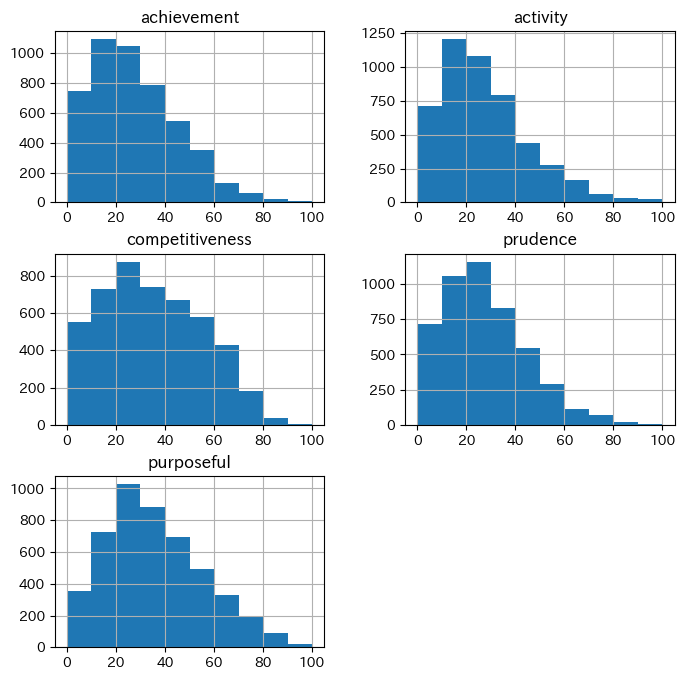

In [ ]:
factor_score_scaling.drop(['employee_id', 'fullname'],axis=1).hist(figsize=(8,8))

## ユークリッド距離_アウトプット

In [ ]:
euclid_distance_hrt.head(3)

,Name1,Name1_fullname,Name1_corporation_id,Name1_achievement,Name1_activity,Name1_competitiveness,Name1_prudence,Name1_purposeful,Name2,Name2_fullname,Name2_corporation_id,Name2_achievement,Name2_activity,Name2_competitiveness,Name2_prudence,Name2_purposeful,Distance,employee_id,Name1_cluster
0,00668205-2e2e-43e0-b375-5d04cff8f83a,佐藤 暖流,None,0.657401,0.522524,0.408715,0.387310,0.367970,02e7a636-5d12-47d8-8a06-398ca38f9f8a,大滝 圭修,56f195ed-73e8-4efe-bdd5-4b26072e6080,0.855182,0.632987,0.610670,0.221459,0.438064,17.58,00668205-2e2e-43e0-b375-5d04cff8f83a,2
1,00668205-2e2e-43e0-b375-5d04cff8f83a,佐藤 暖流,None,0.657401,0.522524,0.408715,0.387310,0.367970,036f4d62-1e0d-40cd-a84d-b8e0dbe05b08,森脇 斗也,56f195ed-73e8-4efe-bdd5-4b26072e6080,0.526088,0.460093,0.463725,0.387258,0.377946,7.76,00668205-2e2e-43e0-b375-5d04cff8f83a,2
2,00668205-2e2e-43e0-b375-5d04cff8f83a,佐藤 暖流,None,0.657401,0.522524,0.408715,0.387310,0.367970,0c88429e-68b4-4b3f-88ff-8763b06eb3c4,三口 廉,56f195ed-73e8-4efe-bdd5-4b26072e6080,0.420628,0.400521,0.198391,0.586272,0.324746,19.72,00668205-2e2e-43e0-b375-5d04cff8f83a,2
3,00668205-2e2e-43e0-b375-5d04cff8f83a,佐藤 暖流,None,0.657401,0.522524,0.408715,0.387310,0.367970,1e507166-04f2-4778-a2bd-19827da77f8d,岡島 喜希,56f195ed-73e8-4efe-bdd5-4b26072e6080,0.198859,0.184284,0.440621,0.277907,0.081876,32.27,00668205-2e2e-43e0-b375-5d04cff8f83a,2
4,00668205-2e2e-43e0-b375-5d04cff8f83a,佐藤 暖流,None,0.657401,0.522524,0.408715,0.387310,0.367970,38ad35a2-c79f-4fe4-9472-3f2ed81392e0,関口 一騎,56f195ed-73e8-4efe-bdd5-4b26072e6080,0.017218,0.260641,0.665659,0.772120,0.472001,41.78,00668205-2e2e-43e0-b375-5d04cff8f83a,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,d86d3620-76af-4b66-b416-d162a8fcd5af,德永 眞哉,56f195ed-73e8-4efe-bdd5-4b26072e6080,0.669951,0.423741,0.402490,0.600990,0.330233,ec67cfd7-61b2-47b5-a716-93c5314e808e,瀬上 真宏,56f195ed-73e8-4efe-bdd5-4b26072e6080,0.635540,0.470178,0.352692,0.535047,0.415849,6.59,d86d3620-76af-4b66-b416-d162a8fcd5af,2
402,d86d3620-76af-4b66-b416-d162a8fcd5af,德永 眞哉,56f195ed-73e8-4efe-bdd5-4b26072e6080,0.669951,0.423741,0.402490,0.600990,0.330233,faee4952-adfd-4829-8d01-1c7edac6a3c7,牧野 航大,56f195ed-73e8-4efe-bdd5-4b26072e6080,0.696071,0.688432,0.046142,0.517546,0.184835,23.67,d86d3620-76af-4b66-b416-d162a8fcd5af,2
403,ea0d023a-243e-436f-a900-fe3da8936b02,山本 寛太,56f195ed-73e8-4efe-bdd5-4b26072e6080,0.530822,0.315876,0.279574,0.585842,0.433428,ec67cfd7-61b2-47b5-a716-93c5314e808e,瀬上 真宏,56f195ed-73e8-4efe-bdd5-4b26072e6080,0.635540,0.470178,0.352692,0.535047,0.415849,10.33,ea0d023a-243e-436f-a900-fe3da8936b02,2
404,ea0d023a-243e-436f-a900-fe3da8936b02,山本 寛太,56f195ed-73e8-4efe-bdd5-4b26072e6080,0.530822,0.315876,0.279574,0.585842,0.433428,faee4952-adfd-4829-8d01-1c7edac6a3c7,牧野 航大,56f195ed-73e8-4efe-bdd5-4b26072e6080,0.696071,0.688432,0.046142,0.517546,0.184835,26.69,ea0d023a-243e-436f-a900-fe3da8936b02,2


### 「名前」を入力すると、類似した人が表示

In [ ]:
def match_ranking(euclid_distance_df):
  # 「名前」を入力すると、類似した人が表示される。
  # 【テスト】corporation_id：56f195ed-73e8-4efe-bdd5-4b26072e6080（レバレジーズ）
  name = input("相性を見たい「名前」を書いてください⇒")
  corporation_id = input("その方の「corporation_id」を書いてください⇒")

  print("その方と相性が良い方は以下になります。" )
  compatibility_filtering = euclid_distance_df[(euclid_distance_df["Name1_fullname"] == name)
                                        | (euclid_distance_df["Name2_fullname"] == name)
                                        & (euclid_distance_df["Name1_corporation_id"] == corporation_id)
                                        & (euclid_distance_df["Name2_corporation_id"] == corporation_id)]

  compatibility_filtering_sort = compatibility_filtering[["Name1_fullname", "Name2_fullname", "Distance"]].sort_values(by="Distance").head(20).reset_index(drop=True)
  return compatibility_filtering_sort

In [ ]:
match_ranking(euclid_distance_df = euclid_distance_hrt)

相性を見たい「名前」を書いてください⇒大滝 圭修
その方の「corporation_id」を書いてください⇒56f195ed-73e8-4efe-bdd5-4b26072e6080
その方と相性が良い方は以下になります。


,Name1_fullname,Name2_fullname,Distance
0,大滝 圭修,白井 陽平,10.69
1,大滝 圭修,岡本 侑樹,14.62
2,大滝 圭修,香川 淳,16.23
3,大滝 圭修,矢野 貴大,17.88
4,大滝 圭修,石田 貴義,18.94
5,大滝 圭修,塚本 貴之,20.28
6,大滝 圭修,稲村 麟,20.82
7,大滝 圭修,森脇 斗也,21.77
8,大滝 圭修,川口 耀平,23.97
9,大滝 圭修,瀬上 真宏,24.41


### 二名の「名前」を入力すると、マッチング度合いが表示

In [ ]:
def match_score(euclid_distance_df):
  # 二名の「名前」を入力すると、マッチング度合いが表示される。
  # 【テスト】corporation_id：56f195ed-73e8-4efe-bdd5-4b26072e6080（レバレジーズ）
  name1 = input("相性を見たい「名前」を書いてください⇒")
  name2 = input("相性を見たい「名前」を書いてください⇒")
  corporation_id = input("その方々の「corporation_id」を書いてください⇒")

  compatibility_filtering = euclid_distance_df[
      ((euclid_distance_df["Name1_fullname"] == name1) | (euclid_distance_df["Name2_fullname"] == name1)) &
      ((euclid_distance_df["Name1_fullname"] == name2) | (euclid_distance_df["Name2_fullname"] == name2)) &
      (euclid_distance_df["Name1_corporation_id"] == corporation_id) &  # Name1_corporation_id が corporation_id と一致する
      (euclid_distance_df["Name2_corporation_id"] == corporation_id)    # Name2_corporation_id が corporation_id と一致する
      ]

  compatibility_filtering_score = compatibility_filtering["Distance"].values[0]
  return print(f"その方々のマッチング度合いは{round(100-compatibility_filtering_score,2)}点/100点です。" ) #「100-距離」で算出

In [ ]:
match_score(euclid_distance_df = euclid_distance_hrt)

相性を見たい「名前」を書いてください⇒大滝 圭修
相性を見たい「名前」を書いてください⇒関口 一騎
その方々の「corporation_id」を書いてください⇒56f195ed-73e8-4efe-bdd5-4b26072e6080
その方々のマッチング度合いは46.62点/100点です。


### 二名の「名前」を入力すると、因子ごとのマッチング度合いが表示

In [ ]:
def factor_score(euclid_distance_df):
  # 二名の「名前」を入力すると、因子ごとのマッチング度合いが表示される。
  # 【テスト】corporation_id：56f195ed-73e8-4efe-bdd5-4b26072e6080（レバレジーズ）
  name1 = input("相性を見たい「名前」を書いてください⇒")
  name2 = input("相性を見たい「名前」を書いてください⇒")
  corporation_id = input("その方々の「corporation_id」を書いてください⇒")

  compatibility_filtering = euclid_distance_df[
      ((euclid_distance_df["Name1_fullname"] == name1) | (euclid_distance_df["Name2_fullname"] == name1)) &
      ((euclid_distance_df["Name1_fullname"] == name2) | (euclid_distance_df["Name2_fullname"] == name2)) &
      (euclid_distance_df["Name1_corporation_id"] == corporation_id) &  # Name1_corporation_id が corporation_id と一致する
      (euclid_distance_df["Name2_corporation_id"] == corporation_id)    # Name2_corporation_id が corporation_id と一致する
      ]

  factor_score_name1 = compatibility_filtering[['Name1_fullname','Name1_achievement','Name1_activity','Name1_competitiveness','Name1_prudence','Name1_purposeful']]
  factor_score_name2 = compatibility_filtering[['Name2_fullname','Name2_achievement','Name2_activity','Name2_competitiveness','Name2_prudence','Name2_purposeful']]
  return factor_score_name1, factor_score_name2

In [ ]:
factor_score_name1, factor_score_name2 = factor_score(euclid_distance_df = euclid_distance_hrt)

相性を見たい「名前」を書いてください⇒関口 一騎
相性を見たい「名前」を書いてください⇒大滝 圭修
その方々の「corporation_id」を書いてください⇒56f195ed-73e8-4efe-bdd5-4b26072e6080


In [ ]:
factor_score_name1

,Name1_fullname,Name1_achievement,Name1_activity,Name1_competitiveness,Name1_prudence,Name1_purposeful
31,大滝 圭修,0.855182,0.632987,0.61067,0.221459,0.438064


In [ ]:
factor_score_name2

,Name2_fullname,Name2_achievement,Name2_activity,Name2_competitiveness,Name2_prudence,Name2_purposeful
31,関口 一騎,0.017218,0.260641,0.665659,0.77212,0.472001


# マハラノビス距離

## マハラノビス距離_実装

### 分割した「input_data」をnumpy配列に変換

In [ ]:
# 必要なカラムのみ抽出
columns_to_extract = ['achievement', 'activity', 'competitiveness', 'prudence', 'purposeful']
filtered_data = input_data[columns_to_extract]

# データ型をfloatに明示的に変換（エラーの場合はNaNに置き換え）
filtered_data = filtered_data.apply(pd.to_numeric, errors='coerce')

# NaNを含む行を削除
filtered_data = filtered_data.dropna()

# 明示的にfloat型のnumpy配列に変換
data_array = filtered_data.to_numpy(dtype=float)

# 対応するemployee_idを取得
ids_array = input_data.loc[filtered_data.index, "employee_id"].to_numpy()

# ユニークなemployee_idを取得
names = np.unique(ids_array)

### マハラノビス距離を測定（データ量が多いため分割で実施）

In [ ]:
# マハラノビス距離を算出
# 全データ(4738行)で実行時間は14分ほど、レコード数は2629960
columns_to_extract = ['achievement', 'activity', 'competitiveness', 'prudence', 'purposeful']
cov = input_data[columns_to_extract].cov() # 共分散行列
inv_cov = np.linalg.inv(cov)  # 共分散行列の逆行列

names = input_data["employee_id"].unique()
mahalanobis_distance_1 = []
for i in range(len(names) // 8):
    for j in range(i + 1, len(names)):
        index1 = np.where(ids_array == names[i])[0][0]
        index2 = np.where(ids_array == names[j])[0][0]
        distance = mahalanobis(data_array[index1], data_array[index2], inv_cov) #マハラノビス距離
        mahalanobis_distance_1.append([names[i], names[j], distance])

KeyboardInterrupt: 

In [ ]:
len(mahalanobis_distance_1)

NameError: name 'mahalanobis_distance_1' is not defined

In [ ]:
# マハラノビス距離を算出
# 全データ(4738行)で実行時間は13分ほど、レコード数は2279496
mahalanobis_distance_2 = []
for i in range(len(names) // 8, len(names) // 4):
    for j in range(i + 1, len(names)):
        index1 = np.where(ids_array == names[i])[0][0]
        index2 = np.where(ids_array == names[j])[0][0]
        distance = mahalanobis(data_array[index1], data_array[index2], inv_cov) #マハラノビス距離
        mahalanobis_distance_2.append([names[i], names[j], distance])

In [ ]:
len(mahalanobis_distance_2)

2279496

In [ ]:
# マハラノビス距離を算出
# 全データ(4738行)で実行時間は11分ほど、レコード数は2274489
mahalanobis_distance_3 = []
for i in range(len(names) // 4, int(len(names) // 2.5)):
    for j in range(i + 1, len(names)):
        index1 = np.where(ids_array == names[i])[0][0]
        index2 = np.where(ids_array == names[j])[0][0]
        distance = mahalanobis(data_array[index1], data_array[index2], inv_cov) #マハラノビス距離
        mahalanobis_distance_3.append([names[i], names[j], distance])

In [ ]:
len(mahalanobis_distance_3)

2274489

In [ ]:
# マハラノビス距離を算出
# 全データ(4738行)で実行時間は10分ほど、レコード数は1981281
mahalanobis_distance_4 = []
for i in range(int(len(names) // 2.5), int(len(names) // 1.75)):
    for j in range(i + 1, len(names)):
        index1 = np.where(ids_array == names[i])[0][0]
        index2 = np.where(ids_array == names[j])[0][0]
        distance = mahalanobis(data_array[index1], data_array[index2], inv_cov) #マハラノビス距離
        mahalanobis_distance_4.append([names[i], names[j], distance])

In [ ]:
len(mahalanobis_distance_4)

1981281

In [ ]:
# マハラノビス距離を算出
# 全データ(4738行)で実行時間は13分ほど、レコード数は1524299
mahalanobis_distance_5 = []
for i in range(int(len(names) // 1.75), int(len(names) // 1.28)):
    for j in range(i + 1, len(names)):
        index1 = np.where(ids_array == names[i])[0][0]
        index2 = np.where(ids_array == names[j])[0][0]
        distance = mahalanobis(data_array[index1], data_array[index2], inv_cov) #マハラノビス距離
        mahalanobis_distance_5.append([names[i], names[j], distance])

In [ ]:
len(mahalanobis_distance_5)

1524299

In [ ]:
# マハラノビス距離を算出
# 全データ(4738行)で実行時間は2分ほど、レコード数は537166
mahalanobis_distance_6 = []
for i in range(int(len(names) // 1.28), len(names)):
    for j in range(i + 1, len(names)):
        index1 = np.where(ids_array == names[i])[0][0]
        index2 = np.where(ids_array == names[j])[0][0]
        distance = mahalanobis(data_array[index1], data_array[index2], inv_cov) #マハラノビス距離
        mahalanobis_distance_6.append([names[i], names[j], distance])

In [ ]:
len(mahalanobis_distance_6)

537166

### 分割したマハラノビス距離を結合し、データ成形

In [ ]:
# 「mahalanobis_distance_1」～「mahalanobis_distance_6」の結合
mahalanobis_distance = mahalanobis_distance_1 + mahalanobis_distance_2 + mahalanobis_distance_3 + mahalanobis_distance_4 + mahalanobis_distance_5 + mahalanobis_distance_6

# データフレーム化
mahalanobis_distance_df = pd.DataFrame(mahalanobis_distance, columns=['Name1', 'Name2', 'Distance'])

# ユークリッド距離を正規化
scaler = MinMaxScaler()
mahalanobis_distance_df['Distance'] = scaler.fit_transform(mahalanobis_distance_df[['Distance']])*100

# 距離の値を小数点第2位で四捨五入
mahalanobis_distance_df["Distance"] = round(mahalanobis_distance_df["Distance"],2)
mahalanobis_distance_df.head(3)

,Name1,Name2,Distance
0,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,0033e100-e265-45cb-8c98-2f20d4d54184,24.08
1,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,004d1690-175d-484f-b35a-46326d8c2bcc,22.30
2,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,00668205-2e2e-43e0-b375-5d04cff8f83a,20.34


### 企業idを追加

In [ ]:
# Name1のcorporation_idを追加
mahalanobis_distance_df = pd.merge(mahalanobis_distance_df, employee_company_data, left_on='Name1', right_on='employee_id', how='left')
mahalanobis_distance_df = mahalanobis_distance_df.rename(columns={'corporation_id': 'Name1_corporation_id'})
mahalanobis_distance_df = mahalanobis_distance_df.drop('employee_id', axis=1)

# Name2のcorporation_idを追加
mahalanobis_distance_df = pd.merge(mahalanobis_distance_df, employee_company_data, left_on='Name2', right_on='employee_id', how='left')
mahalanobis_distance_df = mahalanobis_distance_df.rename(columns={'corporation_id': 'Name2_corporation_id'})
mahalanobis_distance_df = mahalanobis_distance_df.drop('employee_id', axis=1)

# カラムの順序変更
new_column_order = ['Name1', 'Name1_corporation_id','Name2', 'Name2_corporation_id', 'Distance']
mahalanobis_distance_df = mahalanobis_distance_df[new_column_order]
mahalanobis_distance_df.head(3)

,Name1,Name1_corporation_id,Name2,Name2_corporation_id,Distance
0,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,0033e100-e265-45cb-8c98-2f20d4d54184,56f195ed-73e8-4efe-bdd5-4b26072e6080,24.08
1,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,004d1690-175d-484f-b35a-46326d8c2bcc,56f195ed-73e8-4efe-bdd5-4b26072e6080,22.30
2,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,00668205-2e2e-43e0-b375-5d04cff8f83a,None,20.34


### 因子スコア（正規化済み）を追加

In [ ]:
# Name1の因子データを追加
cluster_df = pd.merge(mahalanobis_distance_df, factor_score_scaling, left_on='Name1', right_on='employee_id', how='left')
cluster_df = cluster_df.rename(columns={'achievement': 'Name1_achievement', 'activity': 'Name1_activity','competitiveness':'Name1_competitiveness'
                                          , 'prudence':'Name1_prudence','purposeful':'Name1_purposeful', 'fullname':'Name1_fullname'})

# Name2の因子データを追加
cluster_df = pd.merge(cluster_df, factor_score_scaling, left_on='Name2', right_on='employee_id', how='left')
cluster_df = cluster_df.drop(['employee_id_x','employee_id_y'], axis=1)
mahalanobis_distance_df = cluster_df.rename(columns={'achievement': 'Name2_achievement', 'activity': 'Name2_activity',
                                          'competitiveness':'Name2_competitiveness', 'prudence':'Name2_prudence','purposeful':'Name2_purposeful', 'fullname':'Name2_fullname'})

# カラムの順序変更
new_column_order = ['Name1', 'Name1_fullname', 'Name1_corporation_id','Name1_achievement','Name1_activity','Name1_competitiveness','Name1_prudence','Name1_purposeful',
                    'Name2', 'Name2_fullname', 'Name2_corporation_id','Name2_achievement','Name2_activity','Name2_competitiveness','Name2_prudence','Name2_purposeful', 'Distance']
mahalanobis_distance_df = mahalanobis_distance_df[new_column_order]
mahalanobis_distance_df.head(5)

,Name1,Name1_fullname,Name1_corporation_id,Name1_achievement,Name1_activity,Name1_competitiveness,Name1_prudence,Name1_purposeful,Name2,Name2_fullname,Name2_corporation_id,Name2_achievement,Name2_activity,Name2_competitiveness,Name2_prudence,Name2_purposeful,Distance
0,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,NaN,89eac118-a1ce-45a2-847c-c78c435193ac,39.56943,27.359309,43.171676,67.420275,22.416351,0033e100-e265-45cb-8c98-2f20d4d54184,中野上 龍太郎,56f195ed-73e8-4efe-bdd5-4b26072e6080,34.778784,28.586927,27.806241,26.837185,38.461765,24.08
1,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,NaN,89eac118-a1ce-45a2-847c-c78c435193ac,39.56943,27.359309,43.171676,67.420275,22.416351,004d1690-175d-484f-b35a-46326d8c2bcc,相月 俊紀,56f195ed-73e8-4efe-bdd5-4b26072e6080,83.227109,68.536519,62.797805,68.147450,36.713525,22.30
2,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,NaN,89eac118-a1ce-45a2-847c-c78c435193ac,39.56943,27.359309,43.171676,67.420275,22.416351,00668205-2e2e-43e0-b375-5d04cff8f83a,佐藤 暖流,None,65.740148,52.252440,40.871458,38.730981,36.796996,20.34
3,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,NaN,89eac118-a1ce-45a2-847c-c78c435193ac,39.56943,27.359309,43.171676,67.420275,22.416351,00857a9d-9622-4c65-983e-ae062d6e2b19,ルパワッタゲ アナン,56f195ed-73e8-4efe-bdd5-4b26072e6080,38.825621,41.243004,51.677788,26.170210,32.813109,22.13
4,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,NaN,89eac118-a1ce-45a2-847c-c78c435193ac,39.56943,27.359309,43.171676,67.420275,22.416351,008d1131-c9fc-4177-859c-dedc52575558,黒澤 愛夏,None,69.123035,55.402627,53.658601,40.122979,52.734131,22.49


## HRTメンバに絞る

In [ ]:
# Name1がHRTメンバーに絞る
mahalanobis_distance_hrt = mahalanobis_distance_df[mahalanobis_distance_df['Name1_fullname'].isin(hrt_member)].reset_index(drop=True)

# Name2がHRTメンバーに絞る
mahalanobis_distance_hrt = mahalanobis_distance_hrt[mahalanobis_distance_hrt['Name2_fullname'].isin(hrt_member)].reset_index(drop=True)
mahalanobis_distance_hrt.head(3)

,Name1,Name1_fullname,Name1_corporation_id,Name1_achievement,Name1_activity,Name1_competitiveness,Name1_prudence,Name1_purposeful,Name2,Name2_fullname,Name2_corporation_id,Name2_achievement,Name2_activity,Name2_competitiveness,Name2_prudence,Name2_purposeful,Distance
0,00668205-2e2e-43e0-b375-5d04cff8f83a,佐藤 暖流,None,65.740148,52.25244,40.871458,38.730981,36.796996,02e7a636-5d12-47d8-8a06-398ca38f9f8a,大滝 圭修,56f195ed-73e8-4efe-bdd5-4b26072e6080,85.518198,63.298709,61.066974,22.145851,43.806401,13.91
1,00668205-2e2e-43e0-b375-5d04cff8f83a,佐藤 暖流,None,65.740148,52.25244,40.871458,38.730981,36.796996,036f4d62-1e0d-40cd-a84d-b8e0dbe05b08,森脇 斗也,56f195ed-73e8-4efe-bdd5-4b26072e6080,52.608814,46.009256,46.372544,38.725768,37.794618,7.72
2,00668205-2e2e-43e0-b375-5d04cff8f83a,佐藤 暖流,None,65.740148,52.25244,40.871458,38.730981,36.796996,0c88429e-68b4-4b3f-88ff-8763b06eb3c4,三口 廉,56f195ed-73e8-4efe-bdd5-4b26072e6080,42.062806,40.052106,19.839082,58.627162,32.474569,16.33


In [ ]:
# fullnameがHRTメンバーに絞る
input_data_hrt = input_data[input_data['fullname'].isin(hrt_member)].reset_index(drop=True)
input_data_hrt.head(3)

,employee_id,achievement,activity,competitiveness,prudence,purposeful,fullname
0,00668205-2e2e-43e0-b375-5d04cff8f83a,65.740148,52.252440,40.871458,38.730981,36.796996,佐藤 暖流
1,02e7a636-5d12-47d8-8a06-398ca38f9f8a,85.518198,63.298709,61.066974,22.145851,43.806401,大滝 圭修
2,036f4d62-1e0d-40cd-a84d-b8e0dbe05b08,52.608814,46.009256,46.372544,38.725768,37.794618,森脇 斗也


## マハラノビス距離_クラスター分析

### エルボー法

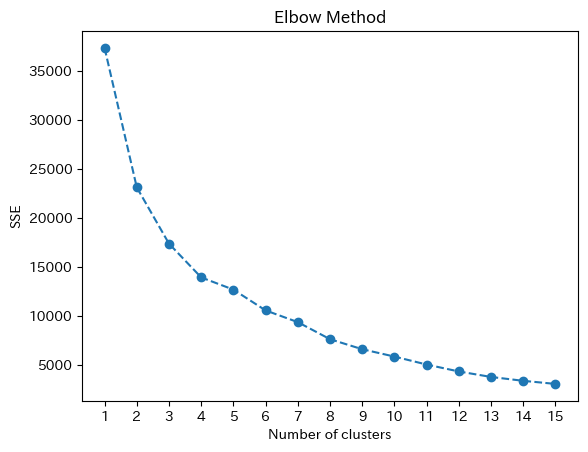

In [ ]:
#【def】エルボー法を実行
elbow_method(max_cluster_num= 15, input_data = input_data_hrt)

### 非階層型クラスター分析

In [ ]:
#マハラノビス距離_クラスター分析
def kmeans_mahalanobis(n_clusters, max_iter=100, random_state=None):
    X = input_data.drop('employee_id', axis=1)

    np.random.seed(random_state)
    cov = np.cov(X, rowvar=False) # 共分散行列
    inv_cov_mahalanobis = np.linalg.inv(cov) # 共分散行列の逆行列

    # 初期のクラスタ中心点をクラスター数分作成
    centers = X.sample(n=n_clusters).to_numpy()

    for _ in range(max_iter):
        # 各点のクラスタ割り当て
        labels = []
        for _, row in X.iterrows(): #_：使用しない、row：カラムと値
          if 'cluster' in row.index:
            distances = [mahalanobis(row.drop('cluster'), center, inv_cov) for center in centers] #各中心点とデータ点のマハラノビス距離
          else:
            distances = [mahalanobis(row, center, inv_cov) for center in centers] #各中心点とデータ点のマハラノビス距離
          labels.append(np.argmin(distances))  # 最も近いマハラノビス距離のインデックスを取得
        X['cluster'] = labels

        # クラスタごとに新しい中心点を計算
        new_centers = X.groupby('cluster').mean().to_numpy()

        # 中心点が収束している場合、終了
        if np.allclose(centers, new_centers):
            break
        centers = new_centers

    # クラスター番号を付与
    factor_score_scaling = input_data
    factor_score_scaling["cluster"] = labels

    return factor_score_scaling

In [ ]:
# def文を実行
n_clusters_mahalanobis = 4  #クラスター数
kmeans_mahalanobis(n_clusters=n_clusters_mahalanobis, random_state=42).head(5)

,employee_id,achievement,activity,competitiveness,prudence,purposeful,cluster
0,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,0.327134,0.192838,0.383012,0.616003,0.674641,1
1,0033e100-e265-45cb-8c98-2f20d4d54184,0.582824,0.574648,0.327768,0.728115,0.897098,0
2,004d1690-175d-484f-b35a-46326d8c2bcc,0.491663,0.259112,0.476509,0.501228,0.582356,2
3,00857a9d-9622-4c65-983e-ae062d6e2b19,0.566319,0.280805,0.473780,0.234083,0.459396,2
4,008d1131-c9fc-4177-859c-dedc52575558,0.320771,0.353634,0.463381,0.963481,1.000000,0


In [ ]:
# Name1の因子データを追加
cluster_df = pd.merge(mahalanobis_distance_df, factor_score_scaling, left_on='Name1', right_on='employee_id', how='left')
cluster_df = cluster_df.rename(columns={'achievement': 'Name1_achievement', 'activity': 'Name1_activity',
                                          'competitiveness':'Name1_competitiveness', 'prudence':'Name1_prudence','purposeful':'Name1_purposeful', 'cluster':'Name1_cluster'})

# Name2の因子データを追加
cluster_df = pd.merge(cluster_df, factor_score_scaling, left_on='Name2', right_on='employee_id', how='left')
cluster_df = cluster_df.drop(['employee_id_x','employee_id_y','cluster'], axis=1)
mahalanobis_distance_df = cluster_df.rename(columns={'achievement': 'Name2_achievement', 'activity': 'Name2_activity',
                                          'competitiveness':'Name2_competitiveness', 'prudence':'Name2_prudence','purposeful':'Name2_purposeful'})

# カラムの順序変更
new_column_order = ['Name1', 'Name1_corporation_id','Name1_achievement','Name1_activity','Name1_competitiveness','Name1_prudence','Name1_purposeful','Name1_cluster',
                    'Name2', 'Name2_corporation_id','Name2_achievement','Name2_activity','Name2_competitiveness','Name2_prudence','Name2_purposeful', 'Distance']
mahalanobis_distance_df = mahalanobis_distance_df[new_column_order]
mahalanobis_distance_df.head(5)

,Name1,Name1_corporation_id,Name1_achievement,Name1_activity,Name1_competitiveness,Name1_prudence,Name1_purposeful,Name1_cluster,Name2,Name2_corporation_id,Name2_achievement,Name2_activity,Name2_competitiveness,Name2_prudence,Name2_purposeful,Distance
0,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,0.327134,0.192838,0.383012,0.616003,0.674641,1,0033e100-e265-45cb-8c98-2f20d4d54184,56f195ed-73e8-4efe-bdd5-4b26072e6080,0.582824,0.574648,0.327768,0.728115,0.897098,34.05
1,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,0.327134,0.192838,0.383012,0.616003,0.674641,1,004d1690-175d-484f-b35a-46326d8c2bcc,56f195ed-73e8-4efe-bdd5-4b26072e6080,0.491663,0.259112,0.476509,0.501228,0.582356,8.60
2,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,0.327134,0.192838,0.383012,0.616003,0.674641,1,00857a9d-9622-4c65-983e-ae062d6e2b19,56f195ed-73e8-4efe-bdd5-4b26072e6080,0.566319,0.280805,0.473780,0.234083,0.459396,29.09
3,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,0.327134,0.192838,0.383012,0.616003,0.674641,1,008d1131-c9fc-4177-859c-dedc52575558,None,0.320771,0.353634,0.463381,0.963481,1.000000,29.21
4,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,0.327134,0.192838,0.383012,0.616003,0.674641,1,00c87eaa-b4ff-4862-8172-d788d26b7b5d,56f195ed-73e8-4efe-bdd5-4b26072e6080,0.342053,0.273011,0.570171,0.634338,0.615522,8.33


### クラスター結果を可視化

In [ ]:
df = pd.read_csv("test_2.csv", encoding='utf-8')  # エンコーディングを指定

In [ ]:
df.drop(['index'], axis=1, inplace=True)

In [ ]:
df

,Name1,Name1_fullname,Name1_corporation_id,Name1_achievement,Name1_activity,Name1_competitiveness,Name1_prudence,Name1_purposeful,Name2,Name2_fullname,Name2_corporation_id,Name2_achievement,Name2_activity,Name2_competitiveness,Name2_prudence,Name2_purposeful,Distance
0,00668205-2e2e-43e0-b375-5d04cff8f83a,佐藤 暖流,NaN,65.740148,52.252440,40.871458,38.730981,36.796996,02e7a636-5d12-47d8-8a06-398ca38f9f8a,大滝 圭修,56f195ed-73e8-4efe-bdd5-4b26072e6080,85.518198,63.298709,61.066974,22.145851,43.806401,13.91
1,00668205-2e2e-43e0-b375-5d04cff8f83a,佐藤 暖流,NaN,65.740148,52.252440,40.871458,38.730981,36.796996,036f4d62-1e0d-40cd-a84d-b8e0dbe05b08,森脇 斗也,56f195ed-73e8-4efe-bdd5-4b26072e6080,52.608814,46.009256,46.372544,38.725768,37.794618,7.72
2,00668205-2e2e-43e0-b375-5d04cff8f83a,佐藤 暖流,NaN,65.740148,52.252440,40.871458,38.730981,36.796996,0c88429e-68b4-4b3f-88ff-8763b06eb3c4,三口 廉,56f195ed-73e8-4efe-bdd5-4b26072e6080,42.062806,40.052106,19.839082,58.627162,32.474569,16.33
3,00668205-2e2e-43e0-b375-5d04cff8f83a,佐藤 暖流,NaN,65.740148,52.252440,40.871458,38.730981,36.796996,1e507166-04f2-4778-a2bd-19827da77f8d,岡島 喜希,56f195ed-73e8-4efe-bdd5-4b26072e6080,19.885854,18.428446,44.062086,27.790691,8.187553,24.76
4,00668205-2e2e-43e0-b375-5d04cff8f83a,佐藤 暖流,NaN,65.740148,52.252440,40.871458,38.730981,36.796996,38ad35a2-c79f-4fe4-9472-3f2ed81392e0,関口 一騎,56f195ed-73e8-4efe-bdd5-4b26072e6080,1.721777,26.064143,66.565901,77.211993,47.200054,44.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,d86d3620-76af-4b66-b416-d162a8fcd5af,德永 眞哉,56f195ed-73e8-4efe-bdd5-4b26072e6080,66.995104,42.374087,40.248991,60.098959,33.023275,ec67cfd7-61b2-47b5-a716-93c5314e808e,瀬上 真宏,56f195ed-73e8-4efe-bdd5-4b26072e6080,63.553967,47.017757,35.269153,53.504687,41.584887,7.85
402,d86d3620-76af-4b66-b416-d162a8fcd5af,德永 眞哉,56f195ed-73e8-4efe-bdd5-4b26072e6080,66.995104,42.374087,40.248991,60.098959,33.023275,faee4952-adfd-4829-8d01-1c7edac6a3c7,牧野 航大,56f195ed-73e8-4efe-bdd5-4b26072e6080,69.607087,68.843229,4.614196,51.754567,18.483499,26.63
403,ea0d023a-243e-436f-a900-fe3da8936b02,山本 寛太,56f195ed-73e8-4efe-bdd5-4b26072e6080,53.082240,31.587592,27.957428,58.584187,43.342756,ec67cfd7-61b2-47b5-a716-93c5314e808e,瀬上 真宏,56f195ed-73e8-4efe-bdd5-4b26072e6080,63.553967,47.017757,35.269153,53.504687,41.584887,9.57
404,ea0d023a-243e-436f-a900-fe3da8936b02,山本 寛太,56f195ed-73e8-4efe-bdd5-4b26072e6080,53.082240,31.587592,27.957428,58.584187,43.342756,faee4952-adfd-4829-8d01-1c7edac6a3c7,牧野 航大,56f195ed-73e8-4efe-bdd5-4b26072e6080,69.607087,68.843229,4.614196,51.754567,18.483499,31.28


In [ ]:
#【def】クラスター結果の可視化を実行
# マラノビス距離：mahalanobis_distance_df
mahalanobis_mds_df = mds(df)

### 因子とdimの相関

<Axes: >

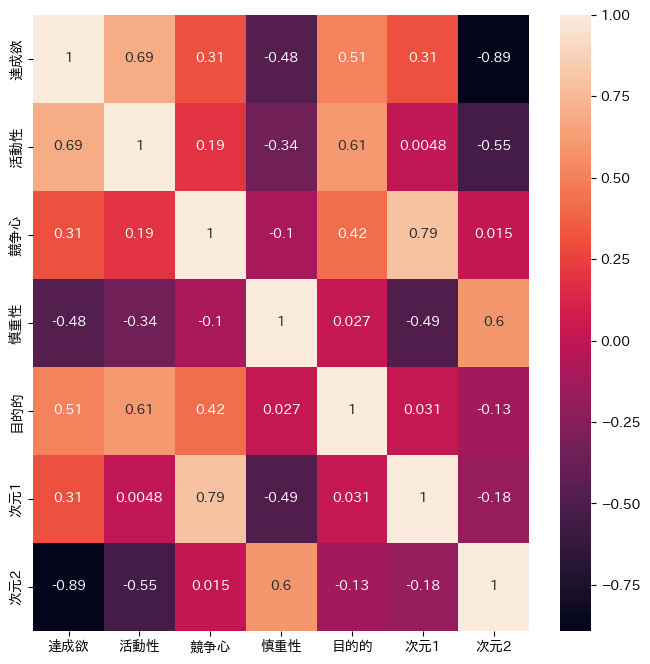

In [ ]:
#相関係数
mahalanobis_distance_hrt = pd.merge(df, mahalanobis_mds_df, left_on='Name1_fullname', right_on='Name', how='left')
mahalanobis_distance_hrt =  mahalanobis_distance_hrt[["Name1_achievement",	"Name1_activity",	"Name1_competitiveness",	"Name1_prudence",	"Name1_purposeful","Dim1",	"Dim2"]]
mahalanobis_distance_hrt_corr = mahalanobis_distance_hrt.rename(columns={'Name1_achievement': '達成欲', 'Name1_activity': '活動性',
                                                                                'Name1_competitiveness':'競争心', 'Name1_prudence':'慎重性','Name1_purposeful':'目的的','Dim1':'次元1','Dim2':'次元2'})

plt.figure(figsize=(8,8))
sns.heatmap(euclid_distance_hrt_corr.corr(), annot=True)

## マハラノビス距離_アウトプット

In [ ]:
match_ranking(euclid_distance_df = mahalanobis_distance_hrt)

相性を見たい「employee_id」を書いてください⇒0013d97e-ea35-492e-b2e3-ba9f0badc5cf
その方の「corporation_id」を書いてください⇒89eac118-a1ce-45a2-847c-c78c435193ac
その方と相性が良い方は以下になります。


,Name1,Name2,Distance
0,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,00c87eaa-b4ff-4862-8172-d788d26b7b5d,8.33
1,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,004d1690-175d-484f-b35a-46326d8c2bcc,8.60
2,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,015ddec2-7e2a-4d53-b320-6329d14f92d9,12.62
3,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,028b344b-4319-4fcf-ba4d-8e1ba54900f6,16.07
4,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,020fbe87-ae25-415f-b8d0-5207735d9ce7,19.36
5,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,022380d3-c46a-4bf1-a1c1-6d327bb3fda8,20.96
6,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,02e7a636-5d12-47d8-8a06-398ca38f9f8a,26.30
7,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,014e447c-1b3e-41a4-8ac5-8d50c10bfeb1,26.91
8,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,0283de03-ebf4-48c4-bf21-61b1f9dcaf40,27.99
9,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,0236b65a-efa7-4903-b931-957395428de5,28.96


In [ ]:
match_score(euclid_distance_df = euclid_distance_hrt)

相性を見たい「employee_id」を書いてください⇒02fc1d8c-0f4c-4772-b863-99b2afa72243
相性を見たい「employee_id」を書いてください⇒031a3093-4418-4b3c-9a1a-011f0930c5d3
その方々の「corporation_id」を書いてください⇒56f195ed-73e8-4efe-bdd5-4b26072e6080
-----------------------
その方々のマッチング度合いは3.29点/100点です。


In [ ]:
factor_score_name1, factor_score_name2 = factor_score(euclid_distance_df = euclid_distance_hrt)

In [ ]:
factor_score_name1

In [ ]:
factor_score_name2

## CSVダウンロード

In [ ]:
# #LowdataをUTF-8でCSVファイルに保存
# file_path_ex = "G:マイドライブ/content/drive/My Drive/mar-データ戦略/事業施策/HRTech/[HRT]適性マッチのマッチングロジック/factorTypeIdと因子名.csv"
# mahalanobis_distance_df.to_csv(file_path_ex, index=False, encoding='utf-8')